In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy

%matplotlib inline

random_state = 239
train_split_ratio = 0.80

## Загрузка и предобработка данных

#### Загрузка и распаковка датасета

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [3]:
! unzip -q /content/drive/MyDrive/vk/data/netflix.zip -d data

#### Предобработка

In [4]:
ratings = pd.read_csv('data/rating.csv')
ratings.sample(n=5)

,userId,movieId,rating,timestamp
19469486,134733,3844,3.5,2008-03-24 23:05:34
14104873,97426,1091,2.5,2009-05-21 20:34:10
3709457,25254,193,3.0,2004-11-30 00:31:25
1841864,12452,224,4.0,1996-05-01 07:50:18
37112,287,185,4.0,1996-11-26 05:18:56


In [5]:
def print_statistic(df): 
    print("Rows in ratings:", df.shape[0])
    print("Unique userId:", df['userId'].nunique())
    print("Unique movieId:", df['movieId'].nunique())
    print("User-Movie rating matrix:", df['userId'].nunique() * df['movieId'].nunique())

In [6]:
print_statistic(ratings)

Rows in ratings: 20000263
Unique userId: 138493
Unique movieId: 26744
User-Movie rating matrix: 3703856792


Для того чтобы убрать нерелевантных пользователей и фильмы и уменьшить датасет, оставим только пользователей, которые поставили хотя бы 500 оценок, и фильмы, которые оценили не меньее 1500 раз. 

In [7]:
users_rat_cnt = ratings[['userId', 'movieId']].groupby(['userId'], as_index=False).count().rename({'movieId': 'cnt'}, axis=1)
movie_rat_cnt = ratings[['userId', 'movieId']].groupby(['movieId'], as_index=False).count().rename({'userId': 'cnt'}, axis=1)

In [8]:
good_users_lst = list(users_rat_cnt[users_rat_cnt['cnt'] >= 500]['userId'])
good_movie_lst = list(movie_rat_cnt[movie_rat_cnt['cnt'] >= 1500]['movieId'])
ratings = ratings[(ratings['userId'].isin(good_users_lst)) 
                & (ratings['movieId'].isin(good_movie_lst))]

In [9]:
print_statistic(ratings)

Rows in ratings: 4844779
Unique userId: 7491
Unique movieId: 2450
User-Movie rating matrix: 18352950


In [10]:
unique_users = ratings['userId'].unique()
unique_movies = ratings['movieId'].unique() 

Разделим датасет на обучачующую и валидационную выборки. Для каждого пользователя отсортируем все поставленные им оценки по времени, и последние $0.2$ части оценок оставим для валидации. 

In [13]:
def split_data(data, train_ratio): 
    users = data['userId'].unique()
    valid_indexes = []

    for u in tqdm(users): 
        cur_user_df = data[data['userId'] == u] 
        rows_to_drop = int((1 - train_ratio) * len(cur_user_df))
        if rows_to_drop == 0: 
          continue
        cur_user_df = cur_user_df.sort_values(by=['timestamp'])
        valid_indexes += list(cur_user_df.tail(rows_to_drop).index)

    return data.drop(valid_indexes), data.loc[valid_indexes]

In [14]:
train_df, test_df = split_data(ratings, train_split_ratio)

100%|██████████| 7491/7491 [01:18<00:00, 95.07it/s] 


Проверим, что соотношение на размеры датасетов получаются правильными

In [15]:
len(train_df) / len(ratings)

0.8009242526852102

## Метрики для оценивания качества

Для оценки качества модели будем использовать две метрики: RMSE и NDCG. Вторая метрика хорошо подходит для нашей задачи, так как одновременно учитывает и ранжирование, и поставленнные пользователями оценки. RMSE для альтернативной проверки качества SVD, а также, чтобы на примере SVD посмотреть кореляцию между RMSE и NDCG. 


In [16]:
def calc_rmse(model, test_df): 
    sum = 0
    for ind in tqdm(test_df.index): 
        row = test_df.loc[ind]
        sum += (row['rating'] - 
                model.predict_score(row['userId'], row['movieId'])) ** 2
    
    return np.sqrt(sum / len(test_df))

In [83]:
def calc_dcg(x): 
    positions = np.log2(np.arange(1, len(x) + 1) + 1)
    return np.sum(x / positions)

# returns dict {'userId': idcg of user}
def calc_idcg(test_df, n): 
    idcg_dict = {} 
    for u in test_df['userId'].unique(): 
        uratings = -np.sort(-np.array(test_df[test_df['userId'] == u]['rating']))
        uratings = uratings[0:min(n, len(uratings))] 
        idcg_dict[u] = calc_dcg(uratings)
    return idcg_dict
        
def calc_ndcg(model, train_df, test_df, n):
    idcg = calc_idcg(test_df, n)
    sum = 0
    cnt = 0
    for u in tqdm(test_df['userId'].unique(), desc='ndcg', position=0):
        rat_dict = test_df[test_df['userId'] == u][['movieId', 'rating']].set_index('movieId').to_dict()['rating']
        viewed_movies = list(train_df[train_df['userId'] == u]['movieId']) 
        recomendations = model.predict_rec(u, N=n, remove_items_list=viewed_movies)
        recomendations = np.array(list(map(lambda x : rat_dict.get(x, 0), recomendations)))
        calc_dcg(recomendations)
        sum += calc_dcg(recomendations) / idcg[u]

    return sum / test_df['userId'].nunique()

## SVD алгоритм

#### Построение модели

In [22]:
# by train dataframe, function build sparse matrix of ratings
def train_to_matrix(train_df): 
    unique_users = train_df['userId'].unique()
    unique_films = train_df['movieId'].unique() 
    users_dict = {unique_users[i]: i for i in range(len(unique_users))}
    movie_dict = {unique_films[i]: i for i in range(len(unique_films))}

    X = np.empty((len(users_dict), len(movie_dict)))
    X[:] = np.nan

    users_train = list(map(lambda x: users_dict[x], train_df['userId'].values))
    movie_train = list(map(lambda x: movie_dict[x], train_df['movieId'].values))
    rating_train = list(train_df['rating'].values)

    for i in range(len(users_train)): 
        X[users_train[i], movie_train[i]] = rating_train[i] 

    return X, users_dict, movie_dict, train_df['rating'].mean()

SVD разложение матрицы

In [23]:
def SVD(X): 
    mask = np.isnan(X)
    masked_arr = np.ma.masked_array(X, mask)
    movie_mean = np.mean(masked_arr, axis=0)

    X = masked_arr.filled(movie_mean) 
    y = np.tile(movie_mean, (X.shape[0],1)).data
    X = X - y

    U, s, V = np.linalg.svd(X, full_matrices=False) 
    s = np.diag(s)

    return U, s, V, y.data, movie_mean.data

Класс рекомандательной модели, основанной на SVD. Основные методы класса: 

* `fit(train)` - обучение на датасете *train*. *train* должен содержать 
столбцы *userId*, *movieId*, *rating* 
* `predict_score(userId, movieId)` - предсказание оценки фильма *movieId* пользователем *userId* 
* `predict_rec(self, userId, items_list, N, remove_items_list)` - топ-$N$ рекомендаций пользователю *userId* из списка *items_list* за исключением фильмов из *remove_items_list*
* `set_k(k)` - изменение размерности отображаемого пространства

In [26]:
class recommender_SVD: 
    def __init__(self):
      self.k = 1

    def recalc_res(self): 
        self.res = (self.U[:, 0:self.k]\
                    .dot(self.s[0:self.k, 0:self.k]))\
                    .dot(self.V[0:self.k,:]) + self.y

    def set_k(self, k): 
        self.k = k 
        self.recalc_res()
    
    def fit(self, train): 
        self.X, self.user_dict, self.movie_dict, self.all_mean = train_to_matrix(train)
        self.U, self.s, self.V, self.y, self.movie_mean = SVD(self.X)
        self.movie_dict_inv = {v: k for k, v in self.movie_dict.items()}
        self.recalc_res()

    def predict_score(self, userId, movieId): 
        if movieId in self.movie_dict.keys(): 
            if userId in self.user_dict.keys():
              res = self.res[self.user_dict[userId], self.movie_dict[movieId]]
            else: 
              res = self.movie_mean[self.movie_dict[movieId]]
        else:
            res = self.all_mean
        return min(5, max(0, res))

    def predict_rec(self, userId, items_list=None, N=None, remove_items_list=None):
        if remove_items_list == None: 
            remove_items_list = [] 
        if items_list == None: 
            items_list = self.movie_dict.keys()
        if N == None: 
            N = len(items_list) 
        
        rec_list = sorted(list(map(lambda x: (self.predict_score(userId, x), x), items_list)), reverse=True)
        rec_list = list(filter(lambda p: p[1] not in remove_items_list, rec_list))[0:N]
        return list(map(lambda p: p[1], rec_list))

#### Обучение и проверка качества модели

In [27]:
svd = recommender_SVD()
svd.fit(train_df)

In [32]:
k_test = np.array([1, 3, 10, 100, 1000])

res_valid_rmse = np.zeros(k_test.shape) 
res_valid_ndcg = np.zeros(k_test.shape) 


for i, k_cur in enumerate(k_test): 
    svd.set_k(k_cur) 
    res_valid_rmse[i] = calc_rmse(svd, test_df) 
    res_valid_ndcg[i] = calc_ndcg(svd, train_df, test_df, 5)

100%|██████████| 7491/7491 [20:38<00:00,  6.05it/s]


In [33]:
res_valid_rmse, res_valid_ndcg

(array([0.85269782, 0.83804056, 0.82189553, 0.81837381, 0.87102626]),
 array([0.14745986, 0.17900246, 0.22039168, 0.24285603, 0.11972899]))

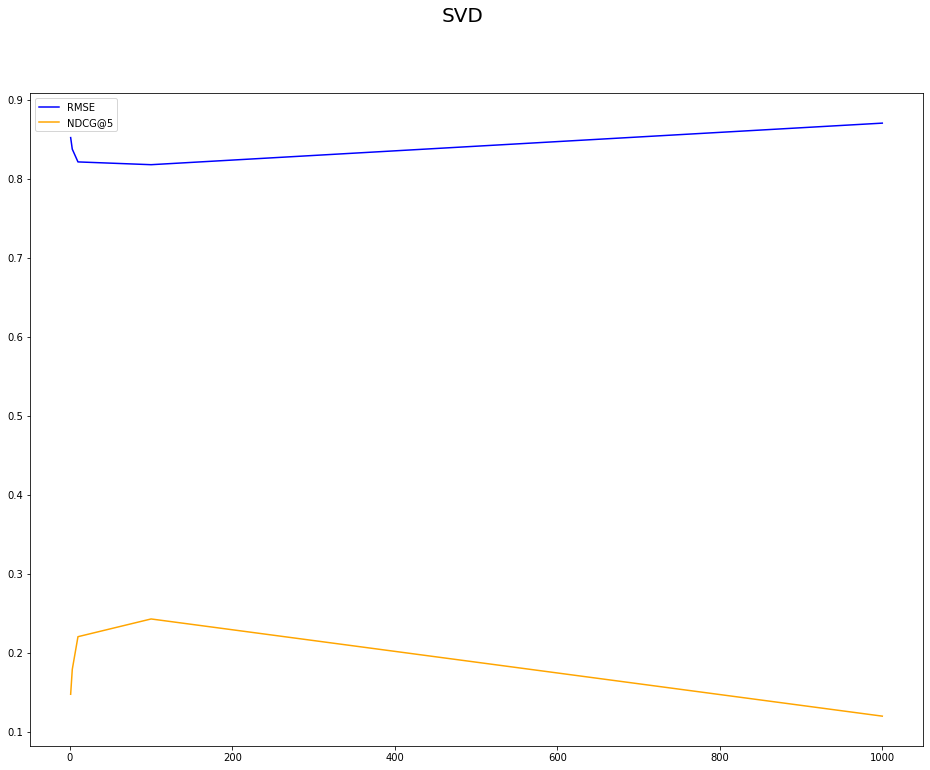

In [34]:
fig, ax = plt.subplots(figsize=(16, 12))
fig.suptitle('SVD', fontsize=20)

ax.plot(k_test, res_valid_rmse, label='RMSE', color='blue')
ax.plot(k_test, res_valid_ndcg, label='NDCG@5', color='orange')
ax.legend(loc='best')

fig.show();

## LightFM

#### Установка LightFM и загрузка дополнительных датасетов

In [ ]:
! pip install lightfm

In [36]:
from lightfm.data import Dataset
from lightfm import LightFM

In [37]:
movie_df = pd.read_csv('data/movie.csv')
genome_df = pd.read_csv('data/genome_scores.csv')

Фильмам проставим только теги, в которых мы уверены, то есть *relevance* которых $\ge 0.9$. 

In [38]:
genome_df = genome_df[(genome_df['movieId'].isin(unique_movies)) & (genome_df['relevance'] >= 0.9)]
movie_df = movie_df[movie_df['movieId'].isin(unique_movies)]

#### Построение матрицы признаков фильмов

У каждого фильма есть два типа признаков: набор жанров и набор тегов. Выделим все эти признаки

In [39]:
tags = genome_df['tagId'].unique()
tags = set(map(lambda x: 'tag_' + str(x), tags))
len(tags)

1001

In [40]:
genres = set().union(*list(map(lambda s: s.split('|'), movie_df['genres'].unique())))
len(genres)

19

In [42]:
movie_features = genres.union(tags)
len(movie_features)

1020

Построим разреженную матрицу признаков фильмов (2х видов: состоящую только из жанров, и состоящую из жанров и тегов) и разреженную матрицу оценок пользователей. 

In [43]:
dataset_g = Dataset()
dataset_gt = Dataset()
dataset_g.fit(unique_users, unique_movies)
dataset_gt.fit(unique_users, unique_movies)

In [44]:
dataset_g.fit_partial(item_features=genres) 
dataset_gt.fit_partial(item_features=movie_features)

In [45]:
def build_mapping_dict(dataset_mapping): 
    lightfm_mapping = {
        'users_map': dataset_mapping[0],
        'user_features_map': dataset_mapping[1],
        'items_map': dataset_mapping[2],
        'item_features_map': dataset_mapping[3],
    }
    lightfm_mapping['users_inv_map'] = {v: k for k, v in lightfm_mapping['users_map'].items()}
    lightfm_mapping['items_inv_map'] = {v: k for k, v in lightfm_mapping['items_map'].items()}

    print('users_mapp len - ', len(lightfm_mapping['users_map']))
    print('user_features_map len - ', len(lightfm_mapping['user_features_map']))
    print('items_map len - ', len(lightfm_mapping['items_map']))
    print('item_features_map len - ', len(lightfm_mapping['item_features_map']))

    return lightfm_mapping

In [46]:
ligthfm_mapping_g = build_mapping_dict(dataset_g.mapping())

users_mapp len -  7491
user_features_map len -  7491
items_map len -  2450
item_features_map len -  2469


In [47]:
ligthfm_mapping_gt = build_mapping_dict(dataset_gt.mapping())

users_mapp len -  7491
user_features_map len -  7491
items_map len -  2450
item_features_map len -  3470


In [48]:
uset_move_rat = list(zip(*(ratings[['userId', 'movieId', 'rating']].to_numpy(dtype=object).T)))

In [49]:
_, train_mat_w_g = dataset_g.build_interactions(uset_move_rat)
_, train_mat_w_gt = dataset_gt.build_interactions(uset_move_rat)

In [52]:
tag_dict = {}
for m in tqdm(genome_df['movieId'].unique()): 
    dict_m = genome_df[genome_df['movieId'] == 1][['tagId', 'relevance']].set_index('tagId').to_dict()['relevance']
    dict_m = [('tag_' + str(k)) for k, _ in dict_m.items()]
    tag_dict[m] = dict_m

genre_dict = movie_df[['movieId', 'genres']].set_index('movieId').to_dict()['genres']
genre_dict = {k : v.split('|') for k, v in genre_dict.items()}
genre_features =  [(k, v) for k, v in genre_dict.items()]

keys = set(genre_dict.keys()).union(set(tag_dict.keys()))
genre_tag_features = [(movie, (genre_dict.get(movie, []) + tag_dict.get(movie, []))) for movie in keys]

100%|██████████| 2383/2383 [00:04<00:00, 537.15it/s]


In [54]:
movie_features_g = dataset_g.build_item_features(genre_features)
movie_features_gt = dataset_gt.build_item_features(genre_tag_features)

#### Построение модели

Класс рекомандательной модели, основанной на LightFM. 

Основные параметры класса:
* `lightfm_mapping` - словарь из пользователей, предметов и фичей из `datset`
* `user_feature` - разреженная матрица из фичей пользователей
* `items_feature` - разреженная матрица из фичей предметов
* `num_threads` - количество потоков на котором будет происходить обучение и предсказывание
* `no_components` - дубликат `no_components` из `LightFM` модели
* `loss` - дубликат `loss` из `LightFM` модели
* `learniong_rate` - дубликат `learniong_rate` из `LightFM` модели
* `random_state` - дубликат `random_state` из `LightFM` модели

Основные методы класса: 

* `fit_partial(interactions)` - обучение на датасете *interactions*, по аналогии с `LightFM.fit_partial`
* `predict_rec(self, user_id, items_list, N, remove_items_list)` - топ-$N$ рекомендаций пользователю *userId* из списка *items_list* за исключением фильмов из *remove_items_list*

In [55]:
class recommender_LightFM: 
    def __init__(self, lightfm_mapping, 
                 no_components=10, 
                 loss = 'warp', 
                 learning_rate=0.05, 
                 random_state=None, 
                 user_features=None, 
                 item_features=None,
                 num_threads=1): 
        self.mapping = lightfm_mapping
        self.no_components = no_components
        self.loss = loss
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.user_features = user_features 
        self.item_features = item_features
        self.num_threads = num_threads
        self.all_items = list(lightfm_mapping['items_map'].values())

        self.lightfm = LightFM(
            no_components = self.no_components, 
            loss = self.loss,
            learning_rate = self.learning_rate, 
            random_state = self.random_state)

    def fit_partial(self, interactions): 
        self.lightfm.fit_partial(
          interactions = interactions, 
          user_features = self.user_features, 
          item_features = self.item_features,
          num_threads = self.num_threads)
    
    def predict_rec(self, user_id, items_list=None, N=None, remove_items_list=None):
        if remove_items_list == None: 
            remove_items_list = [] 
        if items_list == None: 
            items_list = self.all_items
        if N == None: 
            N = len(items_list) 
        
        N_to_select = min(len(items_list), N + len(remove_items_list))
        row_id = self.mapping['users_map'][user_id]
        pred = self.lightfm.predict(user_ids=row_id, 
                                 item_ids=items_list, 
                                 user_features=self.user_features,
                                 item_features=self.item_features, 
                                 num_threads=self.num_threads)
        
        top_items = np.argpartition(pred, -np.arange(N_to_select))[-N_to_select:][::-1]
        top_items = list(map(self.mapping['items_inv_map'].get, top_items))
        return list(set(top_items) - set(remove_items_list))[:N]

#### Обучение и проверка качества модели

In [72]:
lightgm_g = recommender_LightFM(lightfm_mapping=ligthfm_mapping_g, 
                                no_components=64,
                                random_state=random_state,
                                item_features=movie_features_g,
                                num_threads=4)

lightgm_gt = recommender_LightFM(lightfm_mapping=ligthfm_mapping_gt, 
                                 no_components=64,
                                 random_state=random_state,
                                 item_features=movie_features_gt,
                                 num_threads=4)

In [73]:
k_test = []
res_test_ndcg_g = [] 
res_test_ndcg_gt = [] 

for k in tqdm(range(1, 26)): 
    lightgm_g.fit_partial(train_mat_w_g)
    lightgm_gt.fit_partial(train_mat_w_gt)
    if k % 2 == 0 or k <= 3: 
        k_test.append(k)
        res_test_ndcg_g.append(calc_ndcg(lightgm_g, train_df, test_df, 5))
        res_test_ndcg_gt.append(calc_ndcg(lightgm_gt, train_df, test_df, 5))

100%|██████████| 25/25 [1:51:42<00:00, 268.10s/it]


In [77]:
# add final results
k_test.append(25) 
res_test_ndcg_g.append(calc_ndcg(lightgm_g, train_df, test_df, 5))
res_test_ndcg_gt.append(calc_ndcg(lightgm_gt, train_df, test_df, 5))

ndcg: 100%|██████████| 7491/7491 [01:47<00:00, 69.77it/s]


In [80]:
print(res_test_ndcg_g)

[0.19716360301405605, 0.20773088941539034, 0.21209996153390034, 0.2161427942177885, 0.22203348132088246, 0.22764123980713025, 0.23175688765473348, 0.23540316751484555, 0.2385212873966737, 0.24075012571987245, 0.2422020620913256, 0.2448283554081755, 0.24571922290616896, 0.24809573588895073, 0.24948377696373214]


In [81]:
print(res_test_ndcg_gt)

[0.14694999275425605, 0.16262131523696255, 0.17772812537695676, 0.18561002608708102, 0.1930788631845551, 0.19707015860983013, 0.20087409034332138, 0.20411602817388852, 0.20605046630319024, 0.20792374306084355, 0.20994274767999102, 0.21139652776867615, 0.21229526000841684, 0.21305622527249485, 0.21427138894509315]


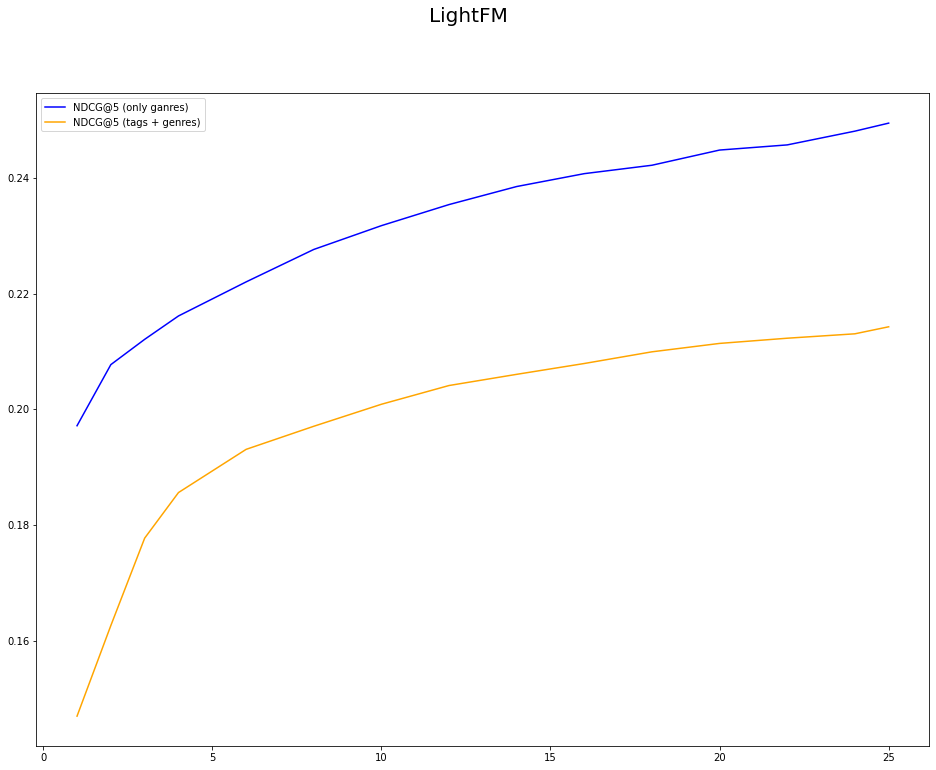

In [82]:
fig, ax = plt.subplots(figsize=(16, 12))
fig.suptitle('LightFM', fontsize=20)

ax.plot(k_test, res_test_ndcg_g, label='NDCG@5 (only ganres)', color='blue')
ax.plot(k_test, res_test_ndcg_gt, label='NDCG@5 (tags + genres)', color='orange')
ax.legend(loc='best')

fig.show();

## Выводы

Таким образом, лучшей по метрике NDCG@5 со скором $\sim 0.25$ оказалась модель LigthFM, причем если в качестве фичей для фильмов брать только жанры. 

Для полноты результатов нужно бы еще: рассмотреть NDCG@k с другими параметрами $k$, рассмотреть дополнительные точки для SVD, запустить LightFM на большем количестве эпох и подрегулировать пороговое значение для тегов. Но, к сожалению, на это не хватило вычислительного времени. 